In [2]:
import sys
!{sys.executable} -m pip install pyltspice matplotlib

In [3]:
from PyLTSpice import SimRunner, SpiceEditor, LTspice, RawRead
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PWL.IMPLY_PWL import Memristor, SerialArchitecture

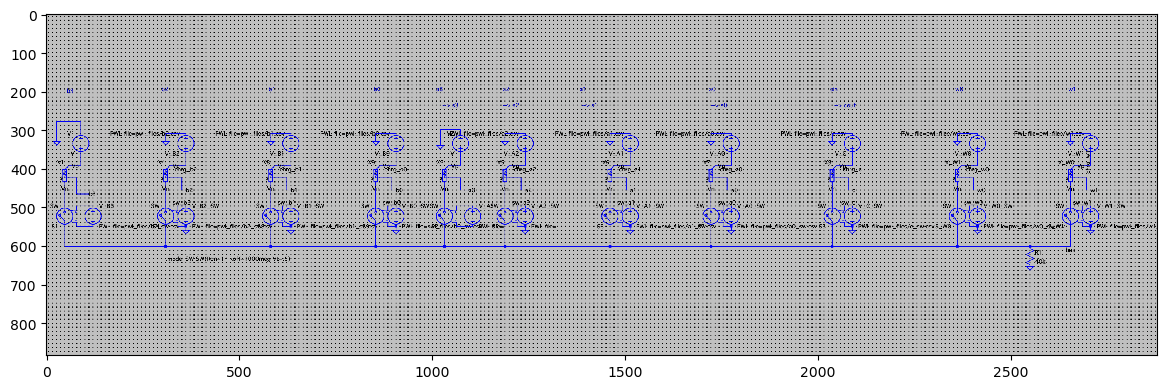

In [4]:
img = mpimg.imread('adder.png')
fig, ax = plt.subplots(figsize=(26, 4))
ax.imshow(img, interpolation='nearest')
plt.tight_layout()

### Initial Tests with the 3 Bit Adder using a Python Script to configure the PWL files for the Memristors

see [IMPLY_PWL.py](PWL/IMPLY_PWL.py)

In [19]:
memristor_names = ['a0', 'a1', 'a2', 'a3', 'b0', 'b1', 'b2', 'b3', 'c', 'w0', 'w1']

step_time = 20

path = 'pwl_files/'

## Use the Memristor class to get access of a collection of functions that can write the PWL file
memristors = [Memristor(name, path) for name in memristor_names]

# dict of memristors mapped by name
m = dict(zip(memristor_names, memristors))

## Use the SerialArchitecture class to get access of a collection of functions that can orchestrate the memristors to create all PWL files
arch = SerialArchitecture(memristors, step_time)

## Set initial state
## Memristors are set to 0 by default
# arch.set_one(m['a0'])
arch.set_one(m['a1'])
# arch.set_one(m['a2'])
arch.set_one(m['b0'])
arch.set_one(m['b1'])
# arch.set_one(m['b2'])
# arch.set_one(m['c'])

# time of initial state configured
init_time = arch.getCurrentTime()
print(init_time)

## Run add algorithm (Bit for Bit)
arch.full_add(m['a0'], m['b0'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])
arch.full_add(m['a1'], m['b1'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])
arch.full_add(m['a2'], m['b2'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])
arch.full_add(m['a3'], m['b3'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])

# close all switches
arch.reset()

## End time
end_time = arch.getCurrentTime()

print(end_time)

arch.print_conf_tocsv()

60
1440


In [8]:
def runSimulation(sim_time, project_name="4BitAddSerial"):
        runner = SimRunner(output_folder='.', simulator=LTspice)  # Configures the simulator to use and output
        netlist = SpiceEditor("{}.asc".format(project_name))  # Open the Spice Model, and creates the .net
        run_netlist_file = "{}_Sim.net".format(project_name)
        tran = ".tran {}u".format(sim_time) # Set the simulation time
        netlist.add_instructions(
                "; Simulation settings",
                tran
        )
        raw, log = runner.run_now(netlist, run_filename=run_netlist_file)

        return raw

In [9]:
def plotTraces(raw_file, memristor_names, sim_time, split=False):
        raw = RawRead(raw_file)

        if split:
                # get colors from default color cycle
                prop_cycle = plt.rcParams['axes.prop_cycle']
                colors = prop_cycle.by_key()['color']
                # plot a lot of subplots with pretty colors
                fig, axes = plt.subplots(len(memristor_names), figsize=(26, 4*len(memristor_names)), sharex=True)
        else:
                fig, ax = plt.subplots(figsize=(26, 4))

        plt.xlim([0, sim_time*1e-6])

        for name in memristor_names:
                trace = raw.get_trace('V({})'.format(name))
                if split:
                        axes[memristor_names.index(name)].plot(raw.get_axis(), trace.get_wave(), label=name, color=colors[memristor_names.index(name) % len(colors)])
                        axes[memristor_names.index(name)].legend()
                else:
                        ax.plot(raw.get_axis(), trace.get_wave(), label=name)
                        ax.legend()
        
        plt.tight_layout()
        plt.show()

In [10]:
def extractStates(raw_file, memristor_names, init_time, threshold=0.5, print_results=True):
        raw = RawRead(raw_file)

        for i, time in enumerate(raw.get_axis()):
                if time >= init_time*1e-6:
                        init_idx = i+1   # +1 to get the next index just to be sure
                        break

        result = {}

        for name in memristor_names:

                trace = raw.get_trace('V({})'.format(name))
                
                result[name] = {'init_state': 1 if trace.get_wave()[init_idx] > threshold else 0, 
                                     'init_value': trace.get_wave()[init_idx], 
                                     'end_state': 1 if trace.get_wave()[-1] > threshold else 0, 
                                     'end_value': trace.get_wave()[-1]}
        
        if print_results:
                for key, res in result.items():
                        print(key, 'init:', res['init_state'], 'end', res['end_state'])
                                     
        
        return result

In [11]:
sim_time = end_time + 100 # 100us after the end of the algorithm
raw_file = runSimulation(sim_time)

NotImplementedError: In this platform LTSpice doesn't have netlist generation capabilities

In [13]:
plotTraces(raw_file, ['a0', 'a1', 'a2', 'a3', 'b0', 'b1', 'b2', 'b3', 'c'], sim_time, split=False)

NameError: name 'raw_file' is not defined

In [14]:
plotTraces(raw_file, ['sw_a0', 'chrg_a0', 'sw_a1', 'chrg_a1', 'sw_a2', 'chrg_a2', 'sw_b0', 'chrg_b0', 'sw_b1', 'chrg_b1', 'sw_b2', 'chrg_b2', 'sw_c', 'chrg_c', 'sw_w0', 'chrg_w0', 'sw_w1', 'chrg_w1'], sim_time, split=True)

NameError: name 'raw_file' is not defined

In [15]:
res = extractStates(raw_file, ['a0', 'a1', 'a2', 'a3', 'b0', 'b1', 'b2', 'b3', 'c'], init_time, threshold=0.5, print_results=True)

NameError: name 'raw_file' is not defined

In [16]:
def generatePWL(memristor_names, initial_state, step_size, path='./'):

    ## Use the Memristor class to get access of a collection of functions that can write the PWL file
    memristors = [Memristor(name, path) for name in memristor_names]

    # dict of memristors mapped by name
    m = dict(zip(memristor_names, memristors))

    ## Use the SerialArchitecture class to get access of a collection of functions that can orchestrate the memristors to create all PWL files
    arch = SerialArchitecture(memristors, step_time)

    ## Set initial state
    ## Memristors are set to 0 by default
    for key, state in initial_state.items():
        if state == 1:
            arch.set_one(m[key])


    # time of initial state configured
    init_time = arch.getCurrentTime()

    ## Run add algorithm (Bit for Bit)
    arch.full_add(m['a0'], m['b0'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])
    arch.full_add(m['a1'], m['b1'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])
    arch.full_add(m['a2'], m['b2'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])
    arch.full_add(m['a3'], m['b3'], m['c'], m['w0'], m['w1'], m['w1'], m['w1'])

    # close all switches
    arch.reset()

    ## End time
    end_time = arch.getCurrentTime()

    arch.print_conf_tocsv()

    return init_time, end_time

In [17]:
initial_states = [
    {'a0': 0, 'a1': 0, 'a2': 0, 'a3': 0, 'b0': 0, 'b1': 0, 'b2': 0, 'b3': 0, 'c': 0},
    {'a0': 1, 'a1': 0, 'a2': 0, 'a3': 0, 'b0': 1, 'b1': 0, 'b2': 0, 'b3': 0, 'c': 0},
    {'a0': 0, 'a1': 1, 'a2': 0, 'a3': 0, 'b0': 0, 'b1': 1, 'b2': 0, 'b3': 0, 'c': 0},
    {'a0': 1, 'a1': 1, 'a2': 0, 'a3': 0, 'b0': 1, 'b1': 1, 'b2': 0, 'b3': 0, 'c': 0},
    {'a0': 0, 'a1': 0, 'a2': 1, 'a3': 0, 'b0': 0, 'b1': 0, 'b2': 1, 'b3': 0, 'c': 0},
    {'a0': 1, 'a1': 0, 'a2': 1, 'a3': 0, 'b0': 1, 'b1': 0, 'b2': 1, 'b3': 0, 'c': 0},
    {'a0': 0, 'a1': 1, 'a2': 1, 'a3': 0, 'b0': 0, 'b1': 1, 'b2': 1, 'b3': 0, 'c': 0},
    {'a0': 1, 'a1': 1, 'a2': 1, 'a3': 0, 'b0': 1, 'b1': 1, 'b2': 1, 'b3': 0, 'c': 0},
    {'a0': 0, 'a1': 0, 'a2': 0, 'a3': 1, 'b0': 0, 'b1': 0, 'b2': 0, 'b3': 1, 'c': 1},
    {'a0': 1, 'a1': 0, 'a2': 0, 'a3': 1, 'b0': 1, 'b1': 0, 'b2': 0, 'b3': 1, 'c': 1},
    {'a0': 0, 'a1': 1, 'a2': 0, 'a3': 1, 'b0': 0, 'b1': 1, 'b2': 0, 'b3': 1, 'c': 1},
    {'a0': 1, 'a1': 1, 'a2': 0, 'a3': 1, 'b0': 1, 'b1': 1, 'b2': 0, 'b3': 1, 'c': 1},
    {'a0': 0, 'a1': 0, 'a2': 1, 'a3': 1, 'b0': 0, 'b1': 0, 'b2': 1, 'b3': 1, 'c': 1},
    {'a0': 1, 'a1': 0, 'a2': 1, 'a3': 1, 'b0': 1, 'b1': 0, 'b2': 1, 'b3': 1, 'c': 1},
    {'a0': 0, 'a1': 1, 'a2': 1, 'a3': 1, 'b0': 0, 'b1': 1, 'b2': 1, 'b3': 1, 'c': 1},
    {'a0': 1, 'a1': 1, 'a2': 1, 'a3': 1, 'b0': 1, 'b1': 1, 'b2': 1, 'b3': 1, 'c': 1},
]


In [18]:
for state in initial_states:
    init_time, end_time = generatePWL(memristor_names, state, 20, path)

    a = state['a0'] + state['a1']*2 + state['a2']*4
    b = state['b0'] + state['b1']*2 + state['b2']*4
    c = state['c']

    total = a + b + c

    print(state, '(Init state: {} + {} (+ Carry {}) = {} + {} = {})'.format(a, b, c, a+b, c, total))

    sim_time = end_time + 100 # 100us after the end of the algorithm
    raw_file = runSimulation(sim_time)
    
    extract_memristor_names = ['a0', 'a1', 'a2', 'a3', 'b0', 'b1', 'b2', 'b3', 'c']
    res = extractStates(raw_file, extract_memristor_names, init_time, threshold=0.5, print_results=False)
    # init_state_conf = [res[key]['init_state'] for key in extract_memristor_names]
    # print(dict(zip(extract_memristor_names, init_state_conf)), '(Init state extracted from trace)')
    end_state_conf = [res[key]['end_state'] for key in extract_memristor_names]
    end_state_dict = dict(zip(extract_memristor_names, end_state_conf))
    sum = end_state_dict['a0'] + end_state_dict['a1']*2 + end_state_dict['a2']*4
    total_extracted = sum + end_state_dict['c']*8

    print(end_state_dict, '(End state extracted from trace: {} Carry{} = {})'.format(sum, end_state_dict['c'], total_extracted), 'check!' if total_extracted == total else 'wrong!')

    print()

{'a0': 0, 'a1': 0, 'a2': 0, 'a3': 0, 'b0': 0, 'b1': 0, 'b2': 0, 'b3': 0, 'c': 0} (Init state: 0 + 0 (+ Carry 0) = 0 + 0 = 0)


NotImplementedError: In this platform LTSpice doesn't have netlist generation capabilities